In [40]:
from collections import defaultdict
!pip install yahoofinancials
from yahoofinancials import YahooFinancials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from statsmodels.nonparametric.kernel_regression import KernelReg


In [41]:
start_date = '2017-01-01'
end_date = '2017-12-31'
stock_code = 'NVDA' # e.g. AMZN, GOOG, FB, NVDA

In [42]:
def preprocess_data(start_date, end_date, stock_code):
    stock_data = YahooFinancials(stock_code).get_historical_price_data(start_date, end_date, 'daily')
    price_data = stock_data[stock_code]['prices']
    columns = ['formatted_date', 'open', 'high', 'low', 'close', 'adjclose', 'volume']
    new_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    df = pd.DataFrame(data=price_data)[columns] # order dataframe columns
    df = df.rename(index=str, columns=dict(zip(columns, new_columns))) # rename dataframe columns
    return df, df['Close'], df['Date']

In [43]:
df, prices, dates = preprocess_data(start_date, end_date, stock_code)

In [44]:
#stock_data = YahooFinancials(stock_code).get_historical_price_data(start_date, end_date, 'daily')
#price_data = stock_data[stock_code]['prices']
#columns = ['formatted_date', 'open', 'high', 'low', 'close', 'adjclose', 'volume']
#new_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
## order dataframe columns
#df = pd.DataFrame(data=price_data)[columns]
## rename dataframe columns
#df = df.rename(index=str, columns=dict(zip(columns, new_columns)))

In [45]:
# set the index from 1 for Nadaraya-Watson kernel regression
prices.index = np.linspace(1, len(prices), len(prices))
dates.index = np.linspace(1, len(dates), len(dates))

In [46]:
dates.head()

1.0    2017-01-03
2.0    2017-01-04
3.0    2017-01-05
4.0    2017-01-06
5.0    2017-01-09
Name: Date, dtype: object

In [47]:
prices.head()

1.0    25.502501
2.0    26.097500
3.0    25.434999
4.0    25.775000
5.0    26.820000
Name: Close, dtype: float64

In [48]:
# https://onlinelibrary.wiley.com/doi/full/10.1111/0022-1082.00265
# reference: https://www.quantopian.com/posts/an-empirical-algorithmic-evaluation-of-technical-analysis
def find_max_min(prices):
    model = KernelReg(prices.values, prices.index.values, var_type='c', bw='cv_ls')
    smooth_prices = pd.Series(data=model.fit([prices.index.values])[0], index=prices.index) # index also from 1

    # use the minima and maxima from the smoothed timeseries
    # to identify true local minima and maxima in the original timeseres
    # by taking the maximum/minimum price within a t-1, t+1 window in the smoothed timeseries
    smooth_prices_max_indices = argrelextrema(smooth_prices.values, np.greater)[0]
    smooth_prices_min_indices = argrelextrema(smooth_prices.values, np.less)[0]

    price_max_indices = []
    for i in smooth_prices_max_indices:
        if 1 < i < len(prices)-1:
            price_max_indices.append(prices.iloc[i-2:i+2].idxmax())

    price_min_indices = []
    for i in smooth_prices_min_indices:
        if 1 < i < len(prices)-1:
            price_min_indices.append(prices.iloc[i-2:i+2].idxmin())

    price_max = prices.loc[price_max_indices]
    price_min = prices.loc[price_min_indices]
    max_min = pd.concat([price_max, price_min]).sort_index()
    max_min = max_min[~max_min.duplicated()] # deduplicate points that are both maximum and minimum
    max_min

    return smooth_prices, smooth_prices_max_indices, smooth_prices_min_indices, \
            price_max_indices, price_min_indices, max_min

In [49]:
smooth_prices, smooth_prices_max_indices, smooth_prices_min_indices, \
            price_max_indices, price_min_indices, max_min = find_max_min(prices)

In [50]:
print(len(max_min))
max_min.head()

67


3.0     25.434999
5.0     26.820000
10.0    25.277500
11.0    25.737499
12.0    26.290001
Name: Close, dtype: float64

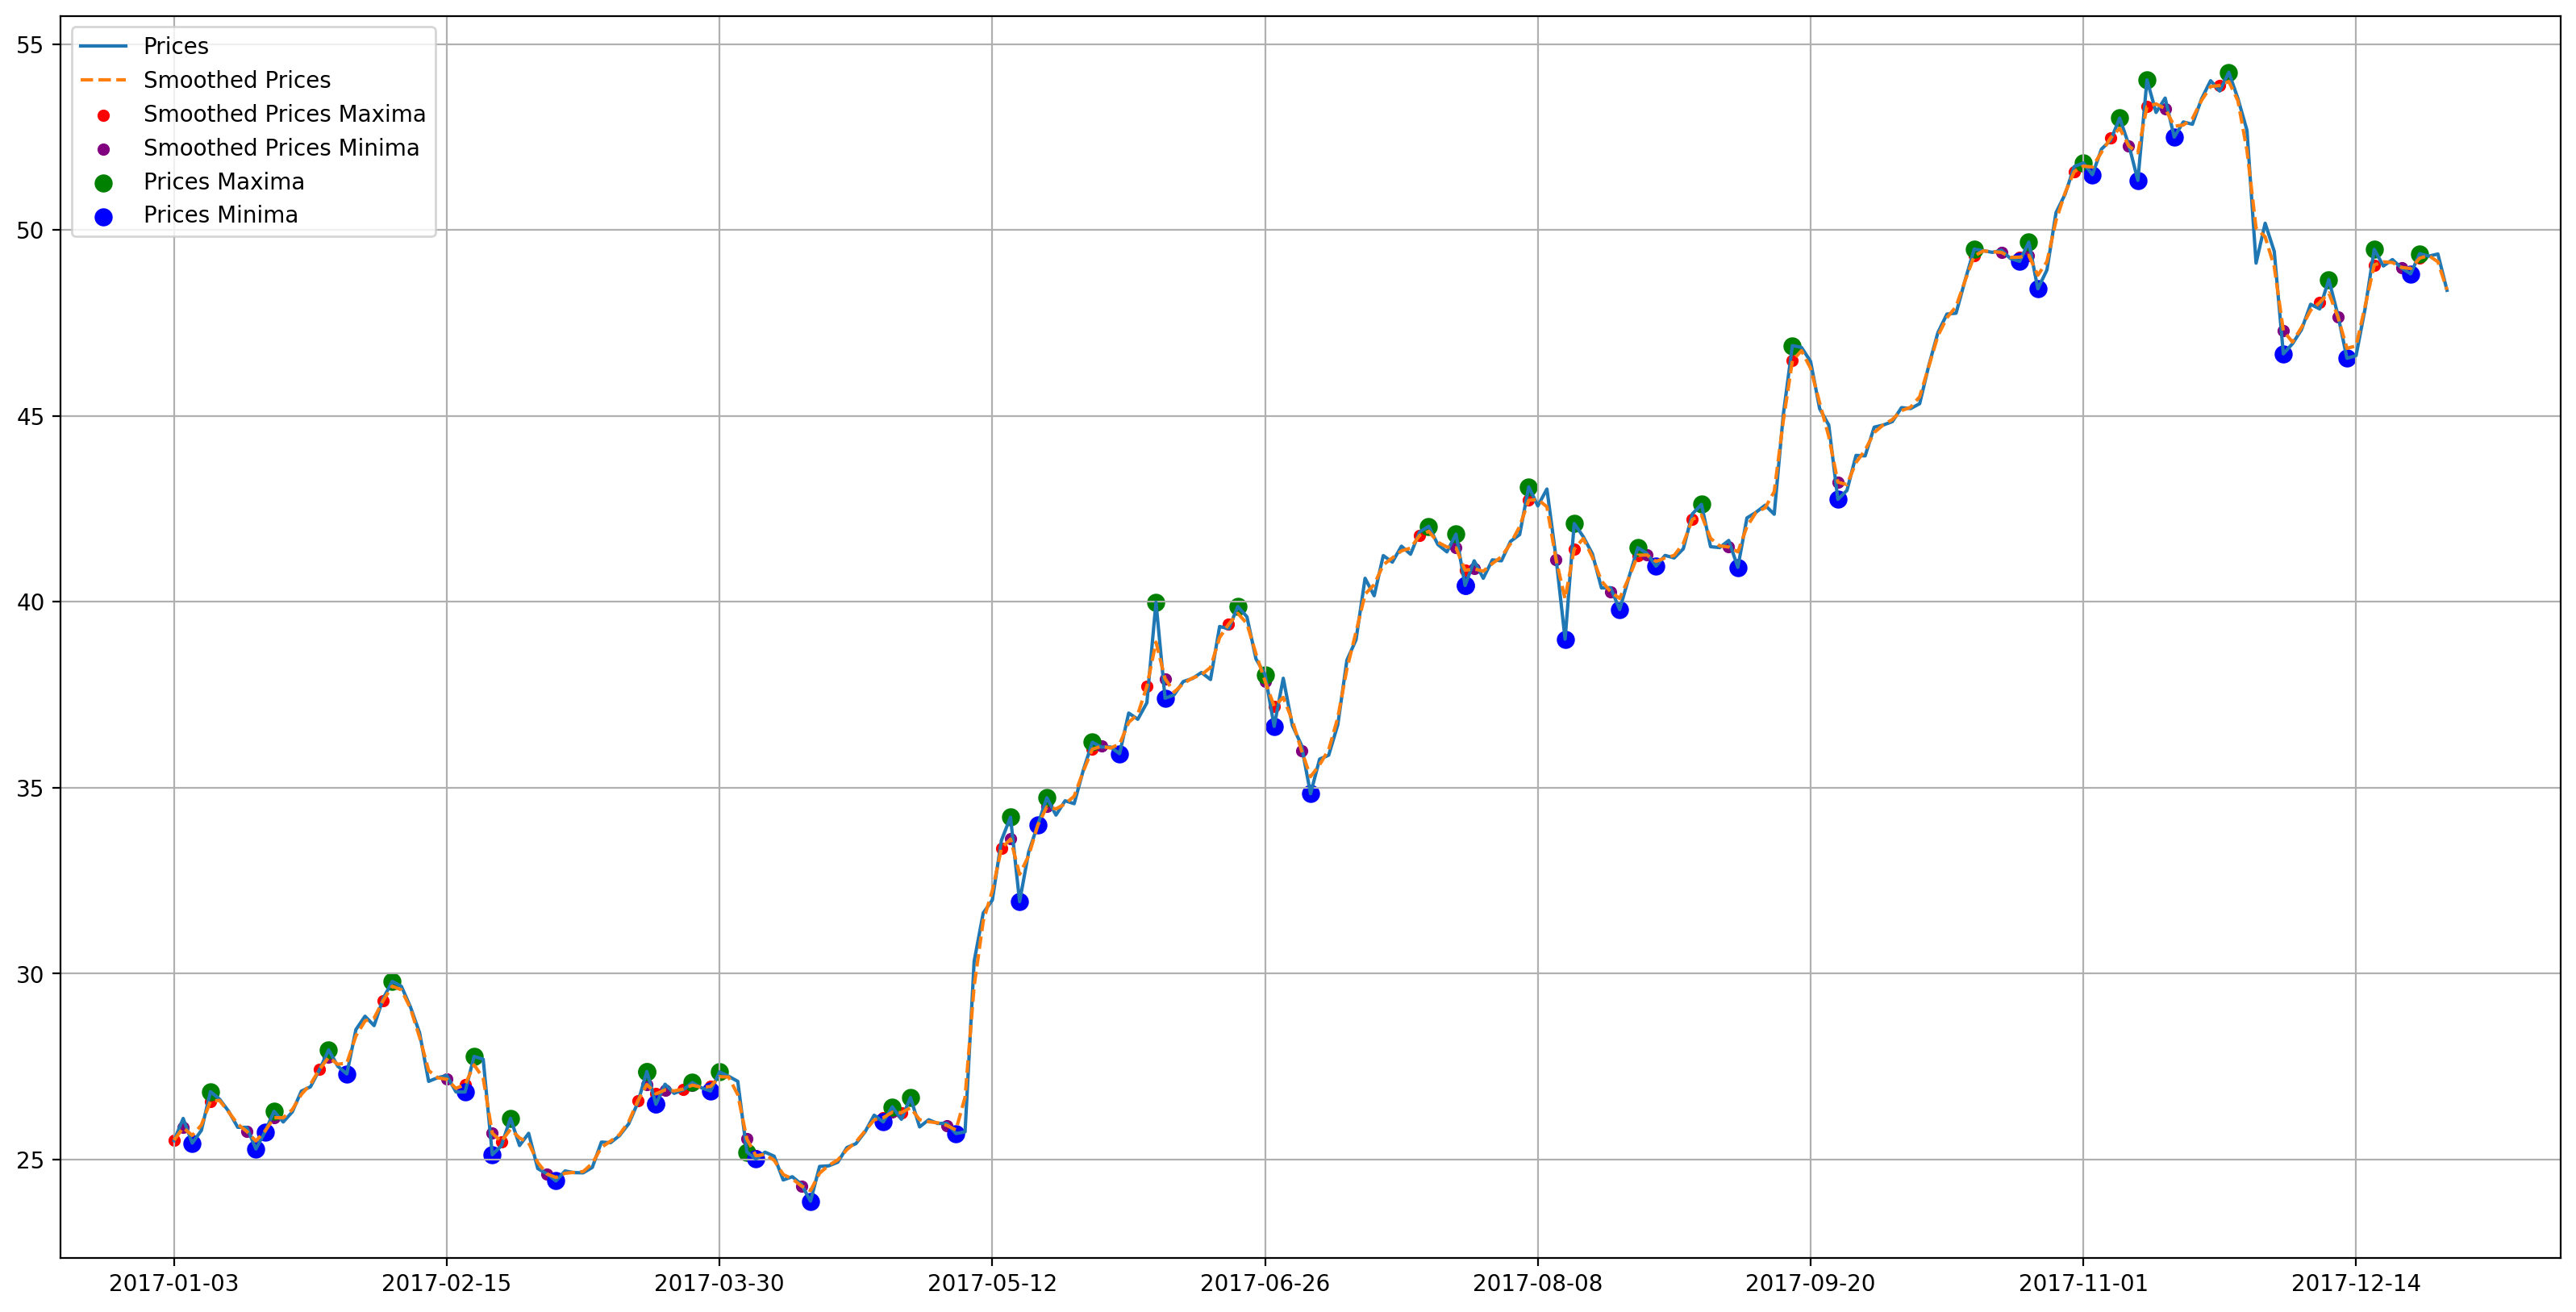

In [51]:
fig, ax = plt.subplots(figsize=(20,10), dpi=200)

ax.plot(dates, prices, label='Prices')
ax.plot(dates, smooth_prices, label='Smoothed Prices', linestyle='dashed')
ax.set_xticks(np.arange(0, len(dates), 30))

smooth_prices_max = smooth_prices.loc[smooth_prices_max_indices]
smooth_prices_min = smooth_prices.loc[smooth_prices_min_indices]
price_max = prices.loc[price_max_indices]
price_min = prices.loc[price_min_indices]

ax.scatter(dates.loc[smooth_prices_max.index], smooth_prices_max.values, s=20, color='red', label='Smoothed Prices Maxima')
ax.scatter(dates.loc[smooth_prices_min.index], smooth_prices_min.values, s=20, color='purple', label='Smoothed Prices Minima')

ax.scatter(dates.loc[price_max.index], price_max.values, s=50, color='green', label='Prices Maxima')
ax.scatter(dates.loc[price_min.index], price_min.values, s=50, color='blue', label='Prices Minima')
ax.legend(loc='upper left')
ax.grid()

In [52]:
def plot_window(dates, prices, smooth_prices,
                smooth_prices_max_indices, smooth_prices_min_indices,
                price_max_indices, price_min_indices,
                start, end, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=(20,10), dpi=200)

    ax.plot(dates.loc[start:end], prices.loc[start:end], label='Prices')
    ax.plot(dates.loc[start:end], smooth_prices.loc[start:end], label='Smoothed Prices', linestyle='dashed')
    ax.set_xticks(np.linspace(0, len(dates.loc[start:end]), 10))
    ax.tick_params(axis='x', rotation=45)

    smooth_prices_max = smooth_prices.loc[smooth_prices_max_indices].loc[start:end]
    smooth_prices_min = smooth_prices.loc[smooth_prices_min_indices].loc[start:end]
    price_max = prices.loc[price_max_indices].loc[start:end]
    price_min = prices.loc[price_min_indices].loc[start:end]

    ax.scatter(dates.loc[smooth_prices_max.index], smooth_prices_max.values, s=20, color='red', label='Smoothed Prices Maxima')
    ax.scatter(dates.loc[smooth_prices_min.index], smooth_prices_min.values, s=20, color='purple', label='Smoothed Prices Minima')

    ax.scatter(dates.loc[price_max.index], price_max.values, s=50, color='green', label='Prices Maxima')
    ax.scatter(dates.loc[price_min.index], price_min.values, s=50, color='blue', label='Prices Minima')
    ax.legend(fontsize='small')
    ax.grid()

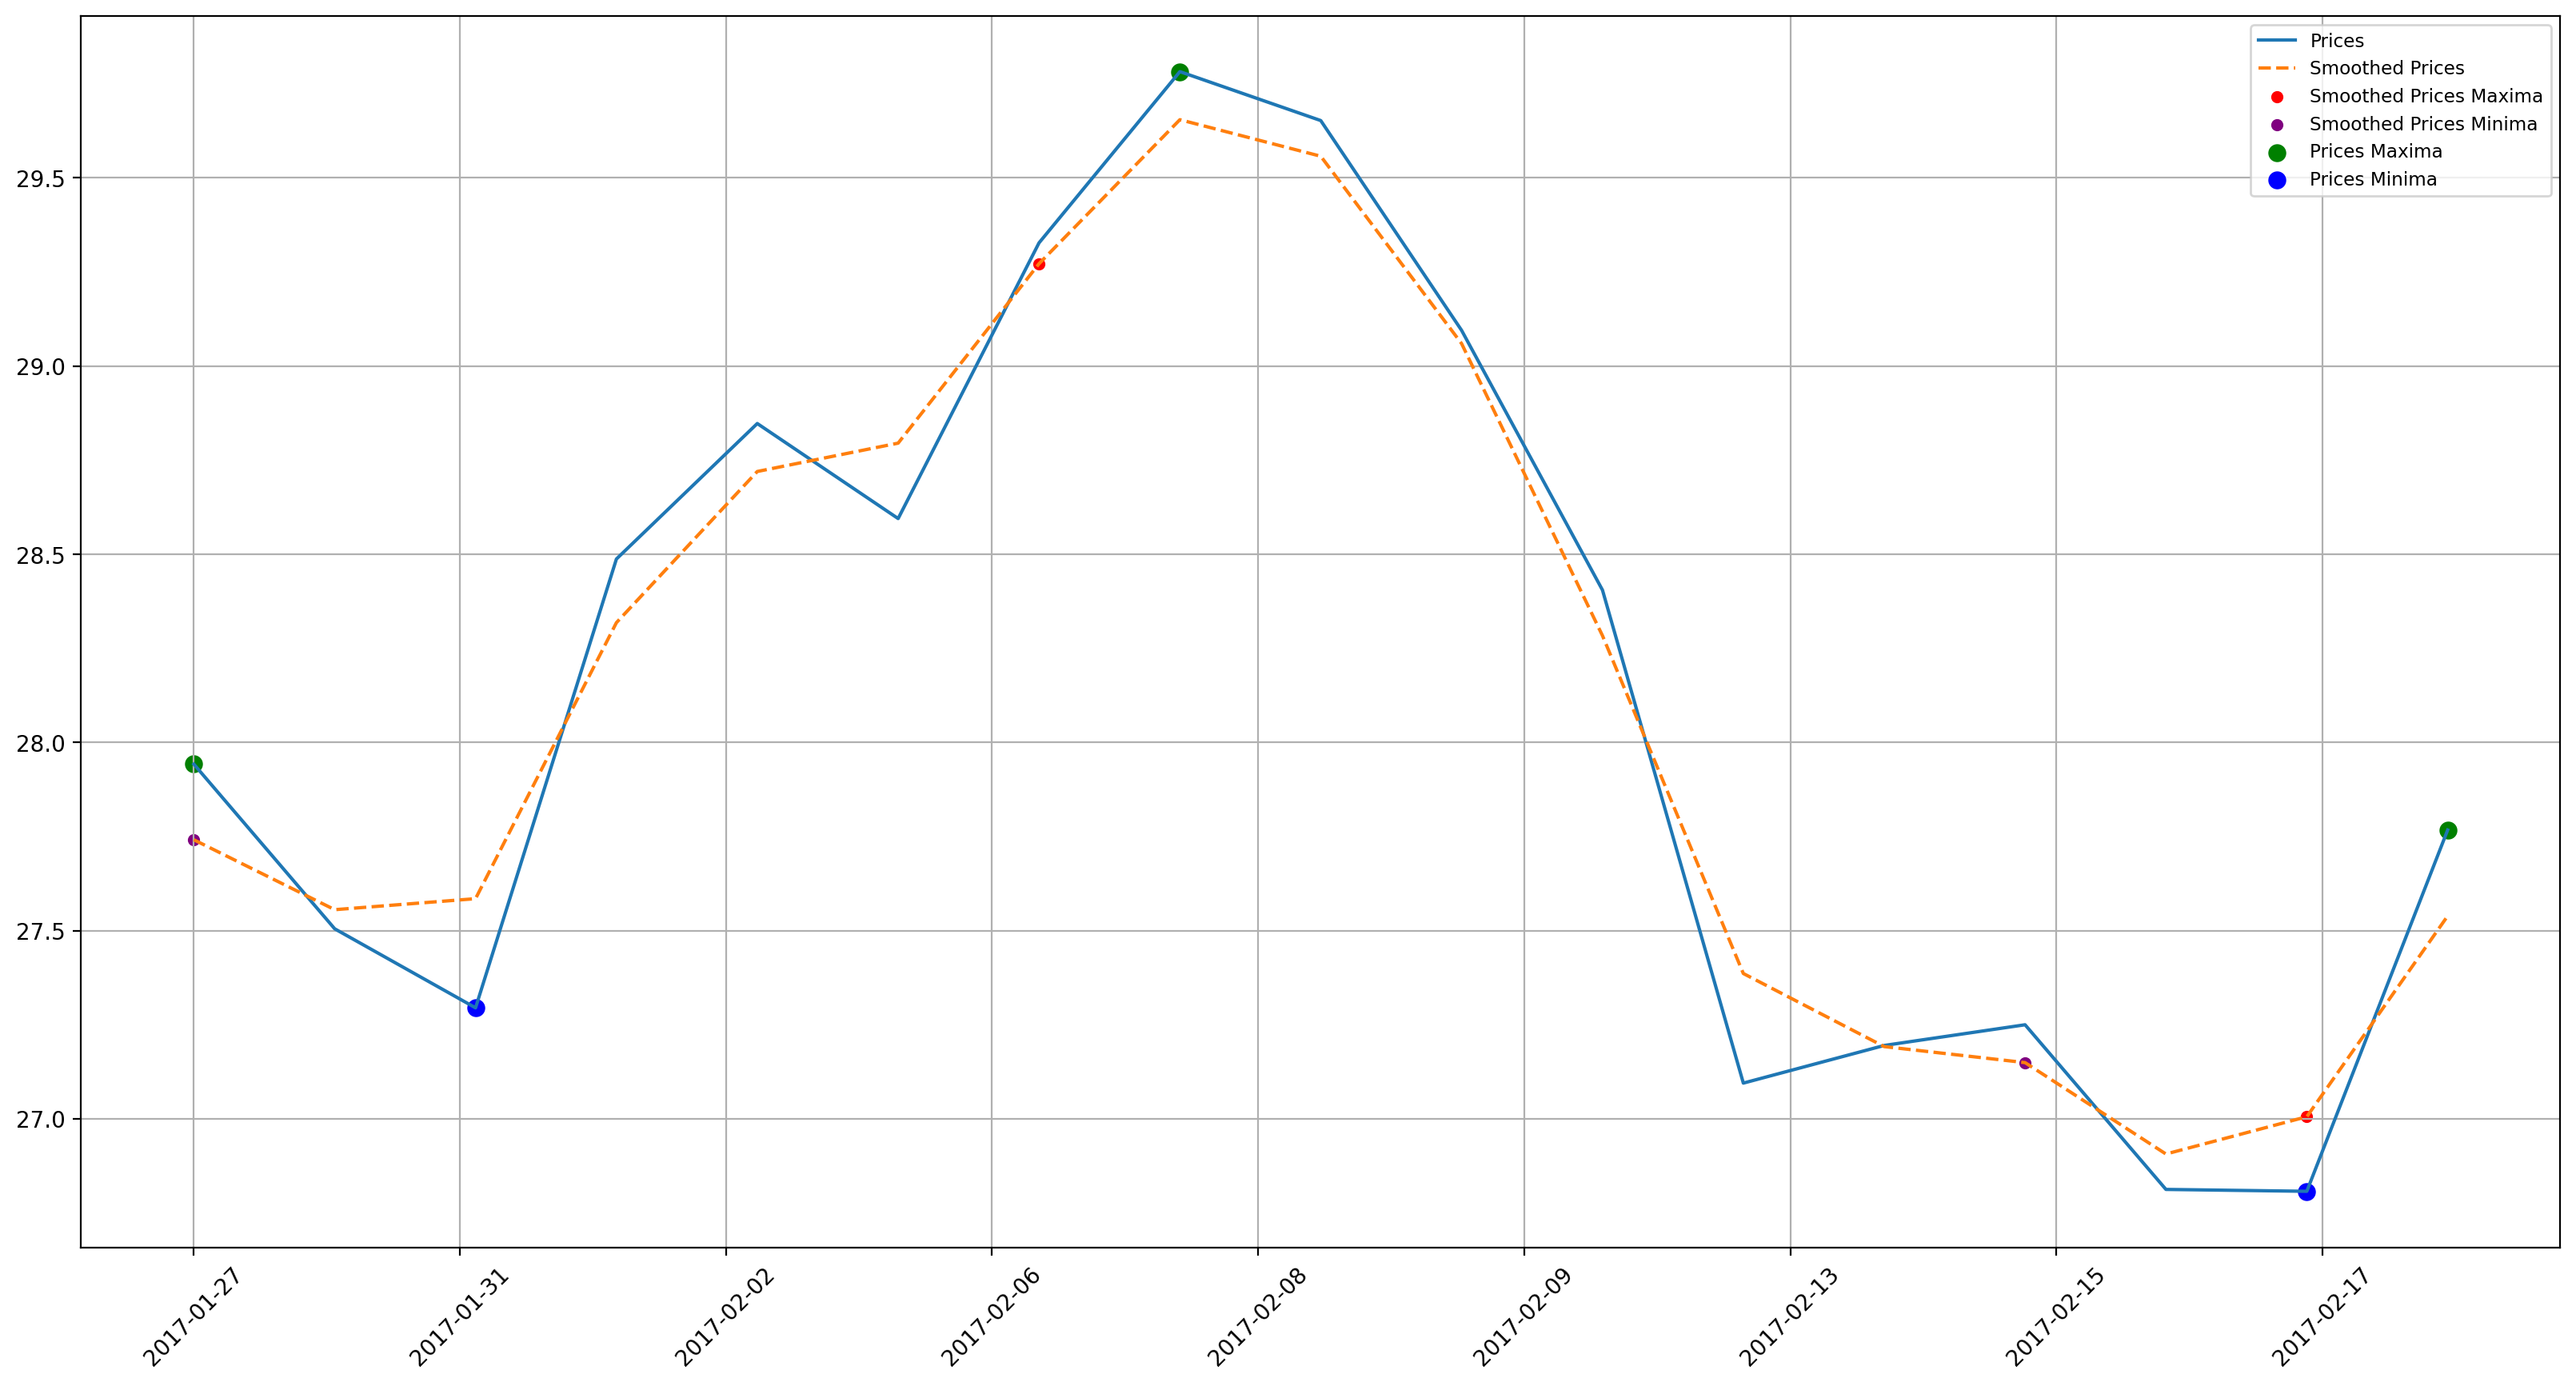

In [53]:
plot_window(dates, prices, smooth_prices,
            smooth_prices_max_indices, smooth_prices_min_indices,
            price_max_indices, price_min_indices,
            start=18, end=34, ax=None)

In [54]:
def find_patterns(max_min):
    patterns = defaultdict(list)

    for i in range(5, len(max_min)):
        window = max_min.iloc[i-5:i]

        # pattern must play out in less than 36 days
        if window.index[-1] - window.index[0] > 35:
            continue

        # Using the notation from the paper to avoid mistakes
        e1, e2, e3, e4, e5 = window.iloc[:5]
        rtop_g1 = np.mean([e1, e3, e5])
        rtop_g2 = np.mean([e2, e4])

        # Head and Shoulders
        if (e1 > e2) and (e3 > e1) and (e3 > e5) and \
            (abs(e1 - e5) <= 0.03*np.mean([e1,e5])) and \
            (abs(e2 - e4) <= 0.03*np.mean([e1,e5])):
                patterns['HS'].append((window.index[0], window.index[-1]))

        # Inverse Head and Shoulders
        elif (e1 < e2) and (e3 < e1) and (e3 < e5) and \
            (abs(e1 - e5) <= 0.03*np.mean([e1,e5])) and \
            (abs(e2 - e4) <= 0.03*np.mean([e1,e5])):
                patterns['IHS'].append((window.index[0], window.index[-1]))

        # Broadening Top
        elif (e1 > e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['BTOP'].append((window.index[0], window.index[-1]))

        # Broadening Bottom
        elif (e1 < e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['BBOT'].append((window.index[0], window.index[-1]))

        # Triangle Top
        elif (e1 > e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['TTOP'].append((window.index[0], window.index[-1]))

        # Triangle Bottom
        elif (e1 < e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['TBOT'].append((window.index[0], window.index[-1]))

        # Rectangle Top
        elif (e1 > e2) and (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
            (min(e1, e3, e5) > max(e2, e4)):
            patterns['RTOP'].append((window.index[0], window.index[-1]))

        # Rectangle Bottom
        elif (e1 < e2) and (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
            (max(e1, e3, e5) > min(e2, e4)):
            patterns['RBOT'].append((window.index[0], window.index[-1]))

    return patterns

In [55]:
patterns = find_patterns(max_min)
patterns

defaultdict(list,
            {'HS': [(18.0, 34.0)],
             'TBOT': [(43.0, 60.0),
              (79.0, 93.0),
              (87.0, 97.0),
              (105.0, 121.0),
              (126.0, 150.0),
              (154.0, 164.0)],
             'RTOP': [(53.0, 61.0)],
             'TTOP': [(109.0, 122.0), (139.0, 154.0), (150.0, 162.0)],
             'IHS': [(143.0, 160.0), (212.0, 221.0)],
             'BTOP': [(162.0, 179.0), (199.0, 211.0), (211.0, 218.0)]})

In [56]:
shorthand_fullname_dict = {'HS': 'Head and Shoulders',
                           'IHS': 'Inverse Head and Shoulders',
                           'BTOP': 'Broadening Top',
                           'BBOT': 'Broadening Bottom',
                           'TTOP': 'Triangle Top',
                           'TBOT': 'Triangle Bottom',
                           'RTOP': 'Rectangle Top',
                           'RBOT': 'Rectangle Bottom'
                          }

In [57]:
def visualize_patterns(dates, prices, smooth_prices,
                       smooth_prices_max_indices, smooth_prices_min_indices,
                       price_max_indices, price_min_indices,
                       patterns, shorthand_fullname_dict):
    for name, end_day_nums in patterns.items():
        print('Pattern Identified: {} \nNumber of Observations: {}'.format(shorthand_fullname_dict[name], len(end_day_nums)))
        rows = int(np.ceil(len(end_day_nums)/2))
        fig, axes = plt.subplots(rows, 2, figsize=(20,5*rows), dpi=200)
        fig.subplots_adjust(hspace=0.5)
        axes = axes.flatten()
        i = 0
        for start_date, end_date in end_day_nums:
            plot_window(dates, prices, smooth_prices,
                smooth_prices_max_indices, smooth_prices_min_indices,
                price_max_indices, price_min_indices,
                start=start_date-1, end=end_date+1, ax=axes[i])
            i += 1
        plt.show()

Pattern Identified: Head and Shoulders 
Number of Observations: 1


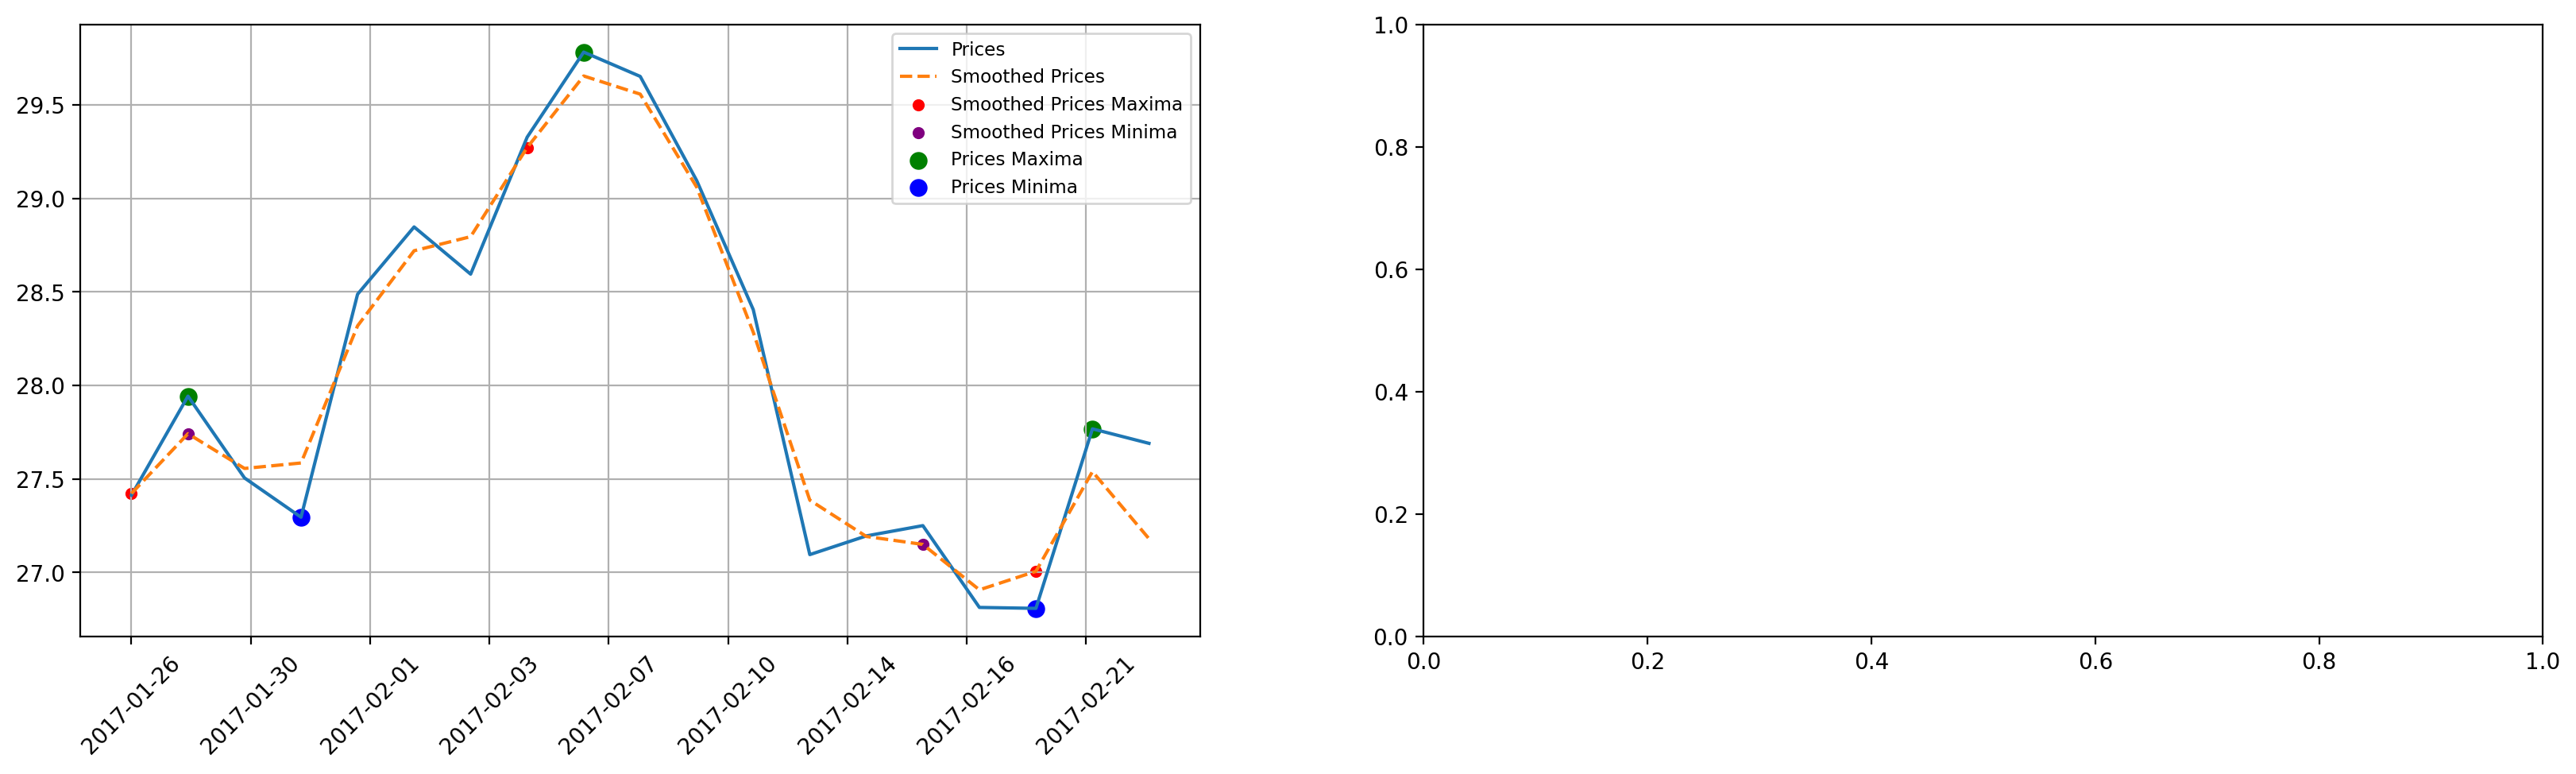

Pattern Identified: Triangle Bottom 
Number of Observations: 6


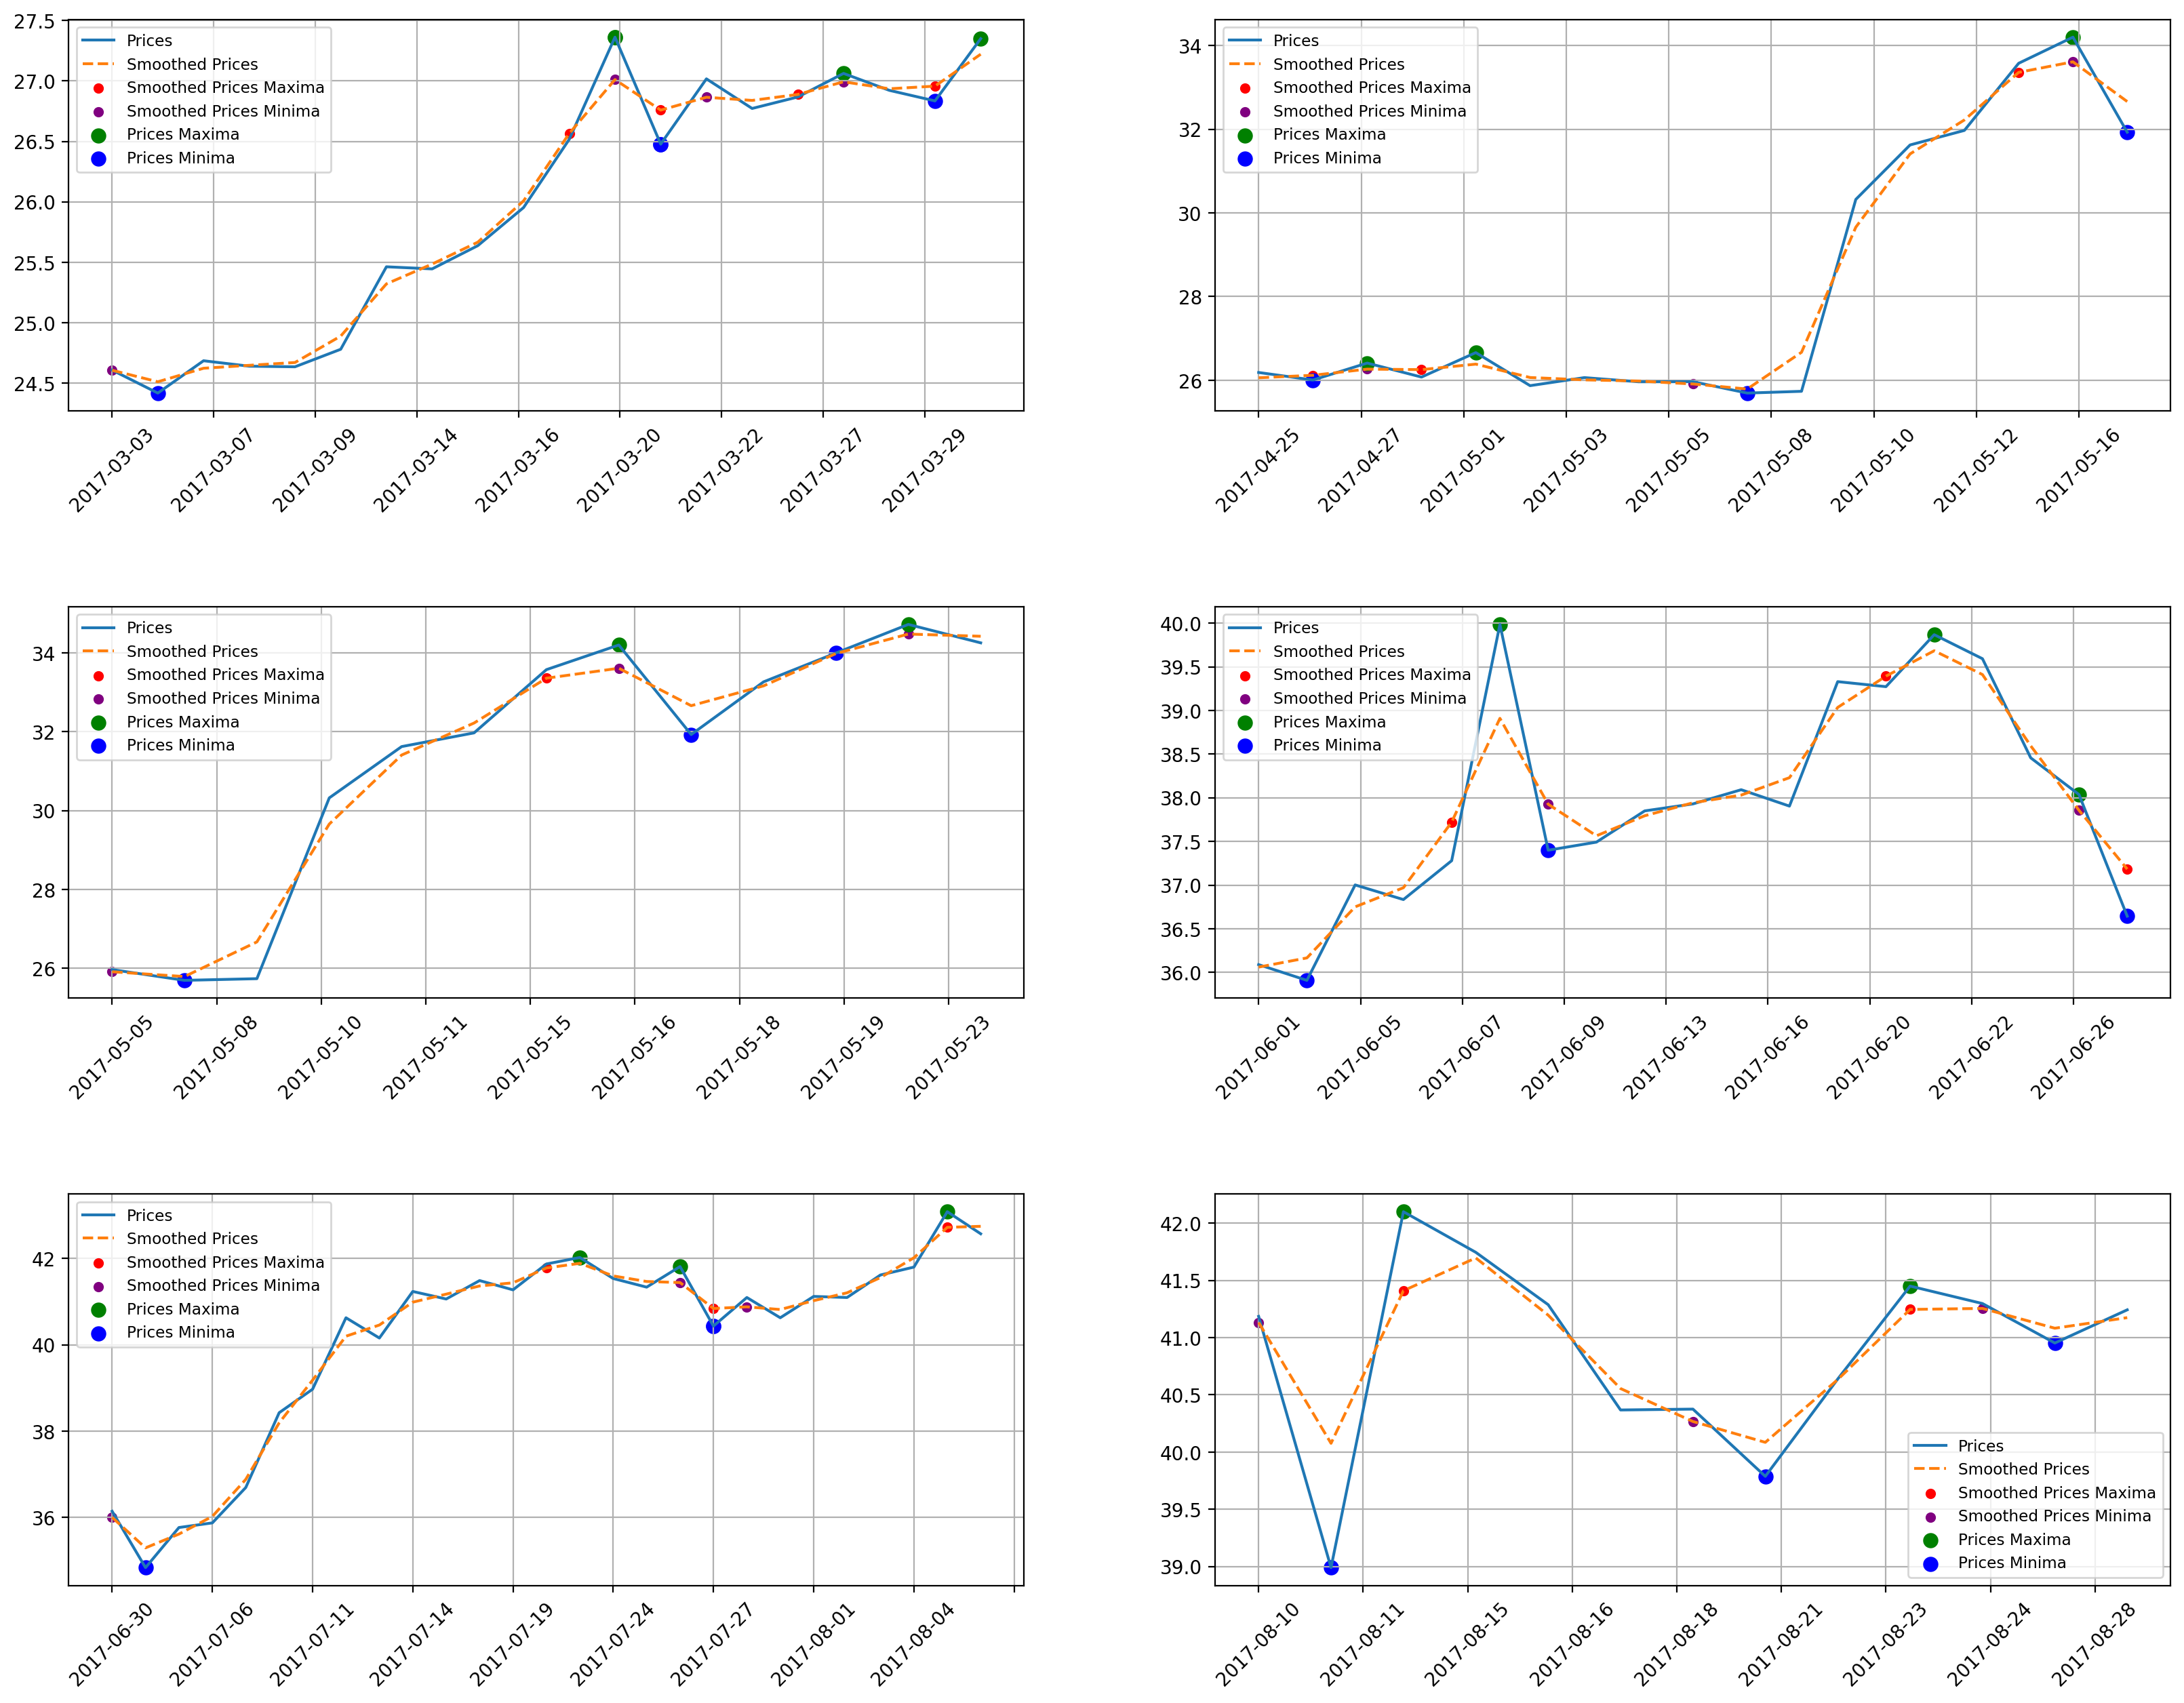

Pattern Identified: Rectangle Top 
Number of Observations: 1


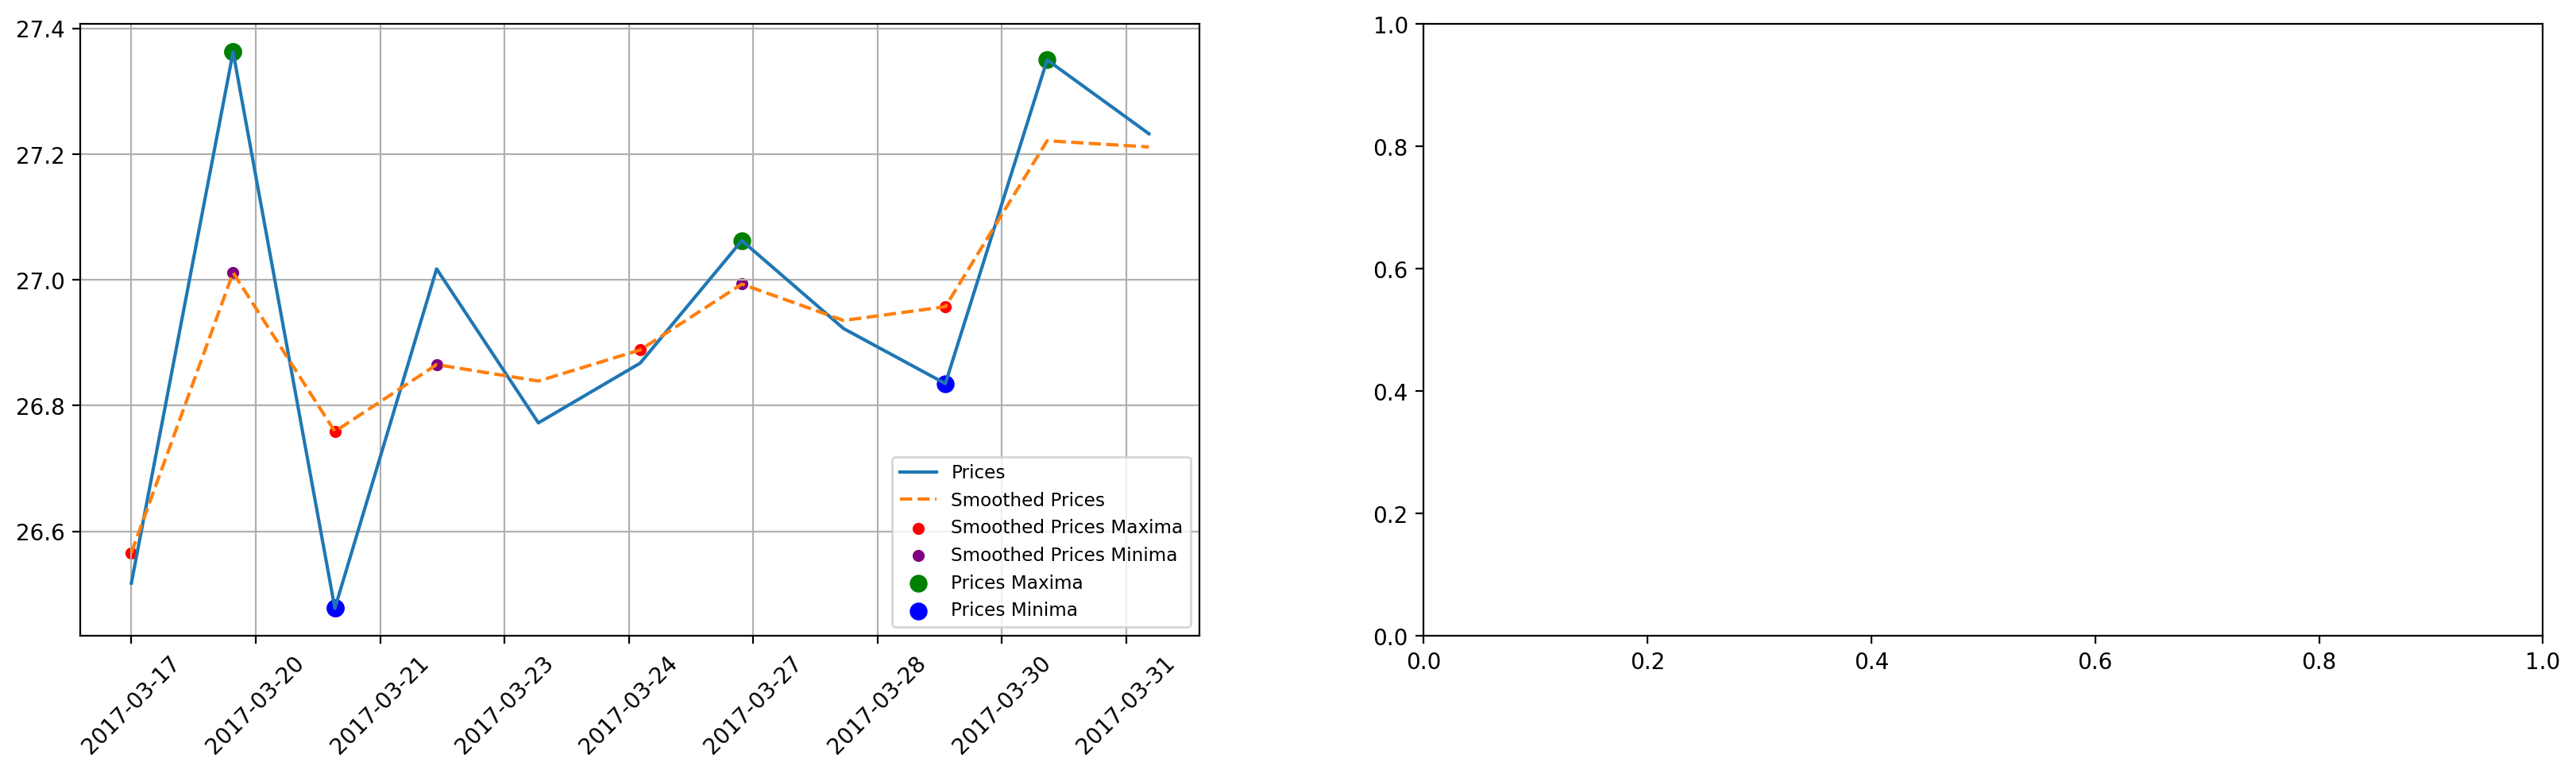

Pattern Identified: Triangle Top 
Number of Observations: 3


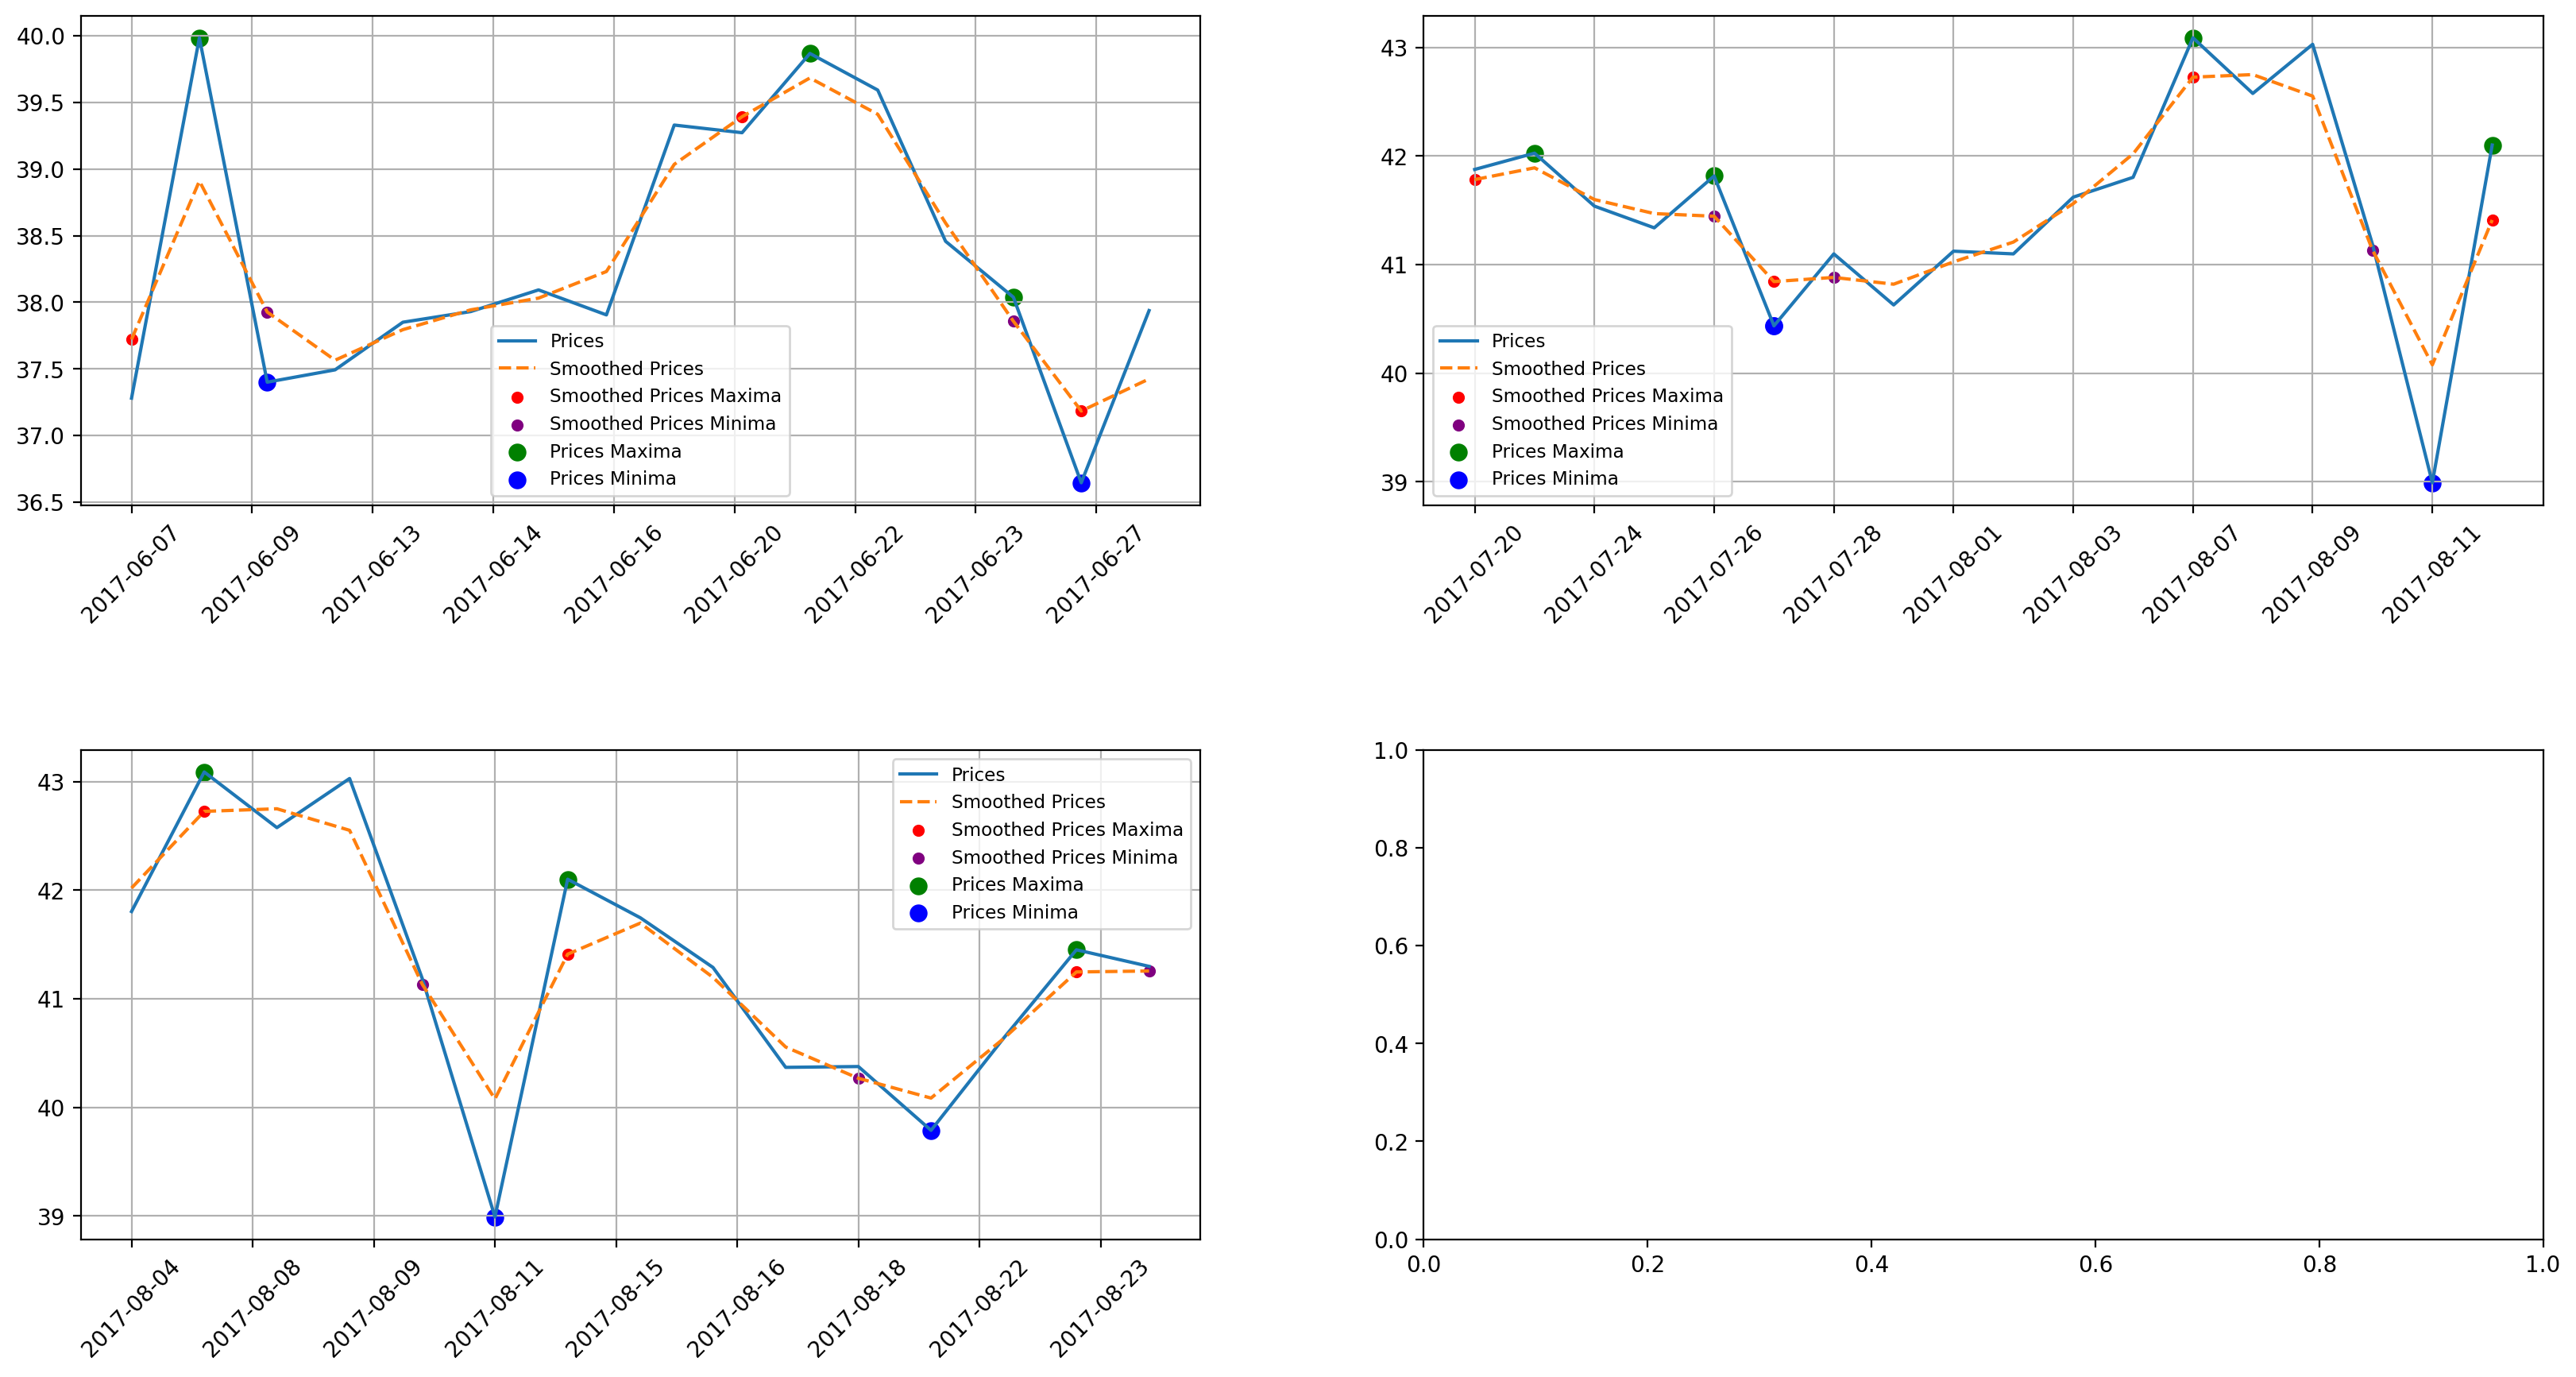

Pattern Identified: Inverse Head and Shoulders 
Number of Observations: 2


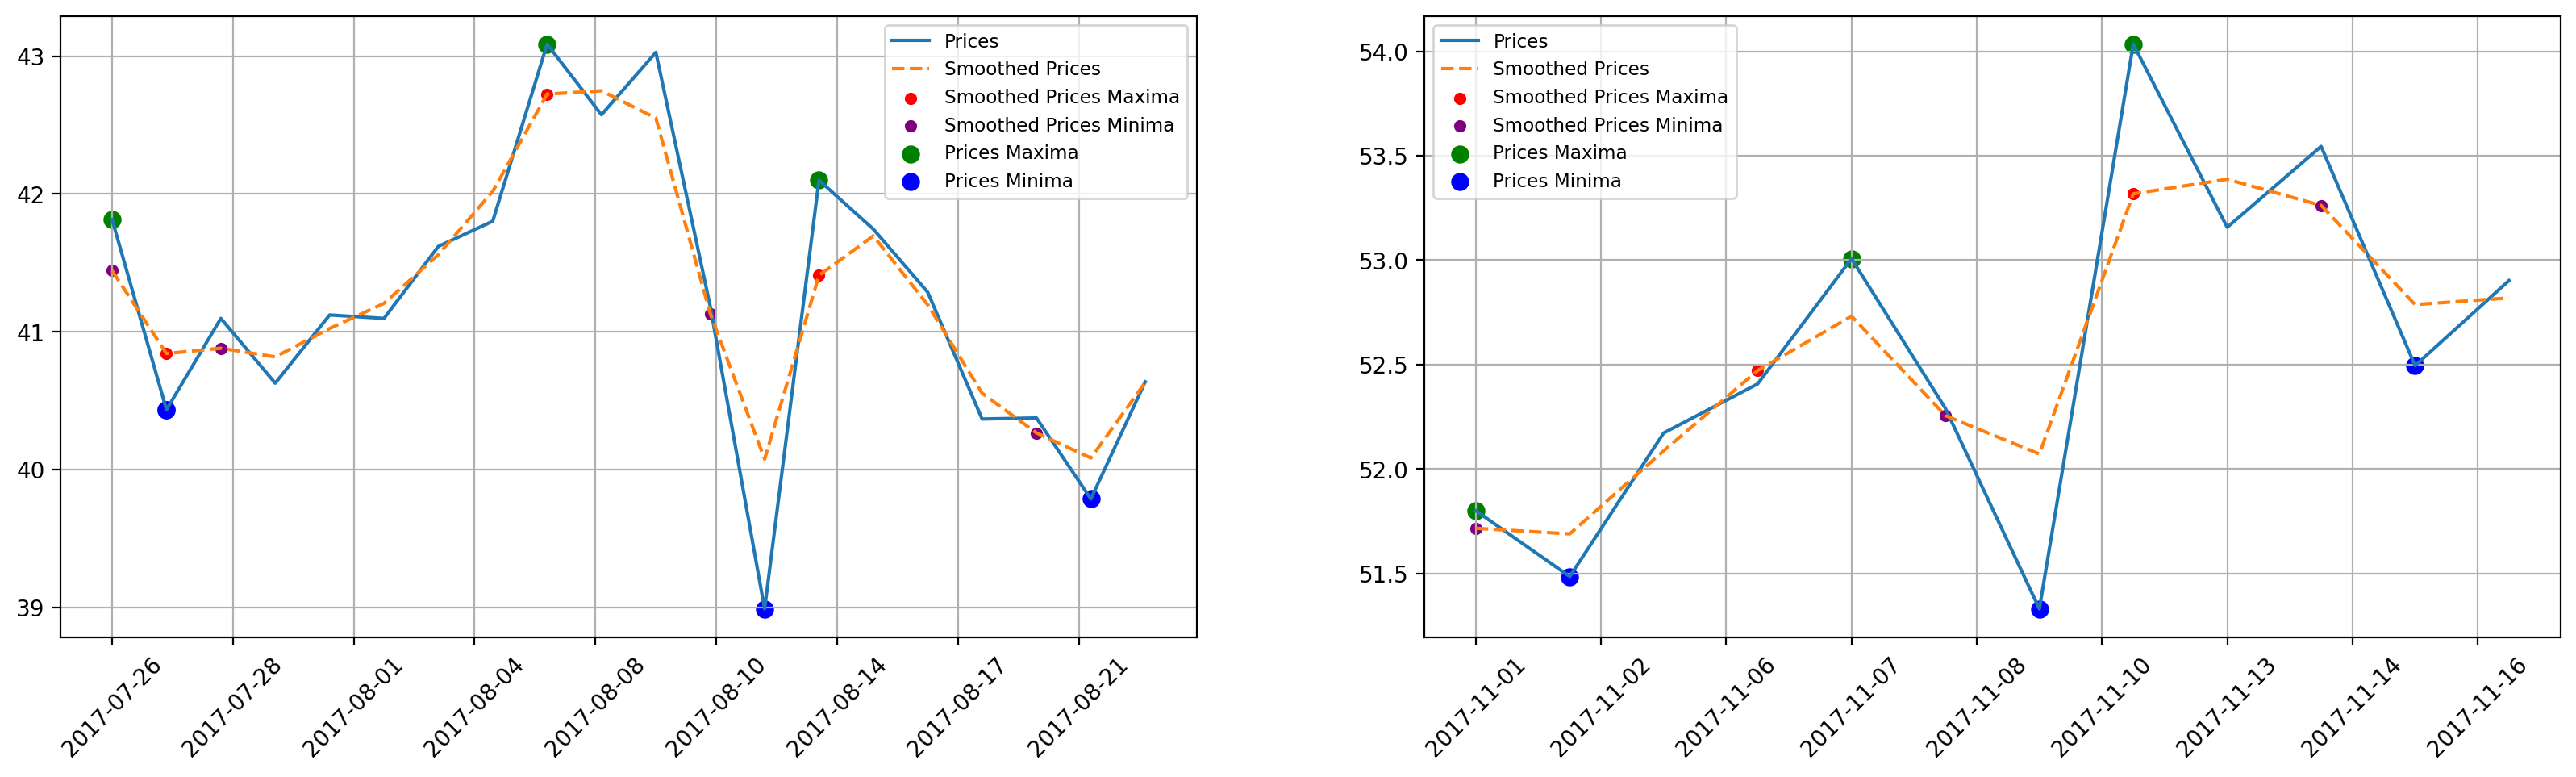

Pattern Identified: Broadening Top 
Number of Observations: 3


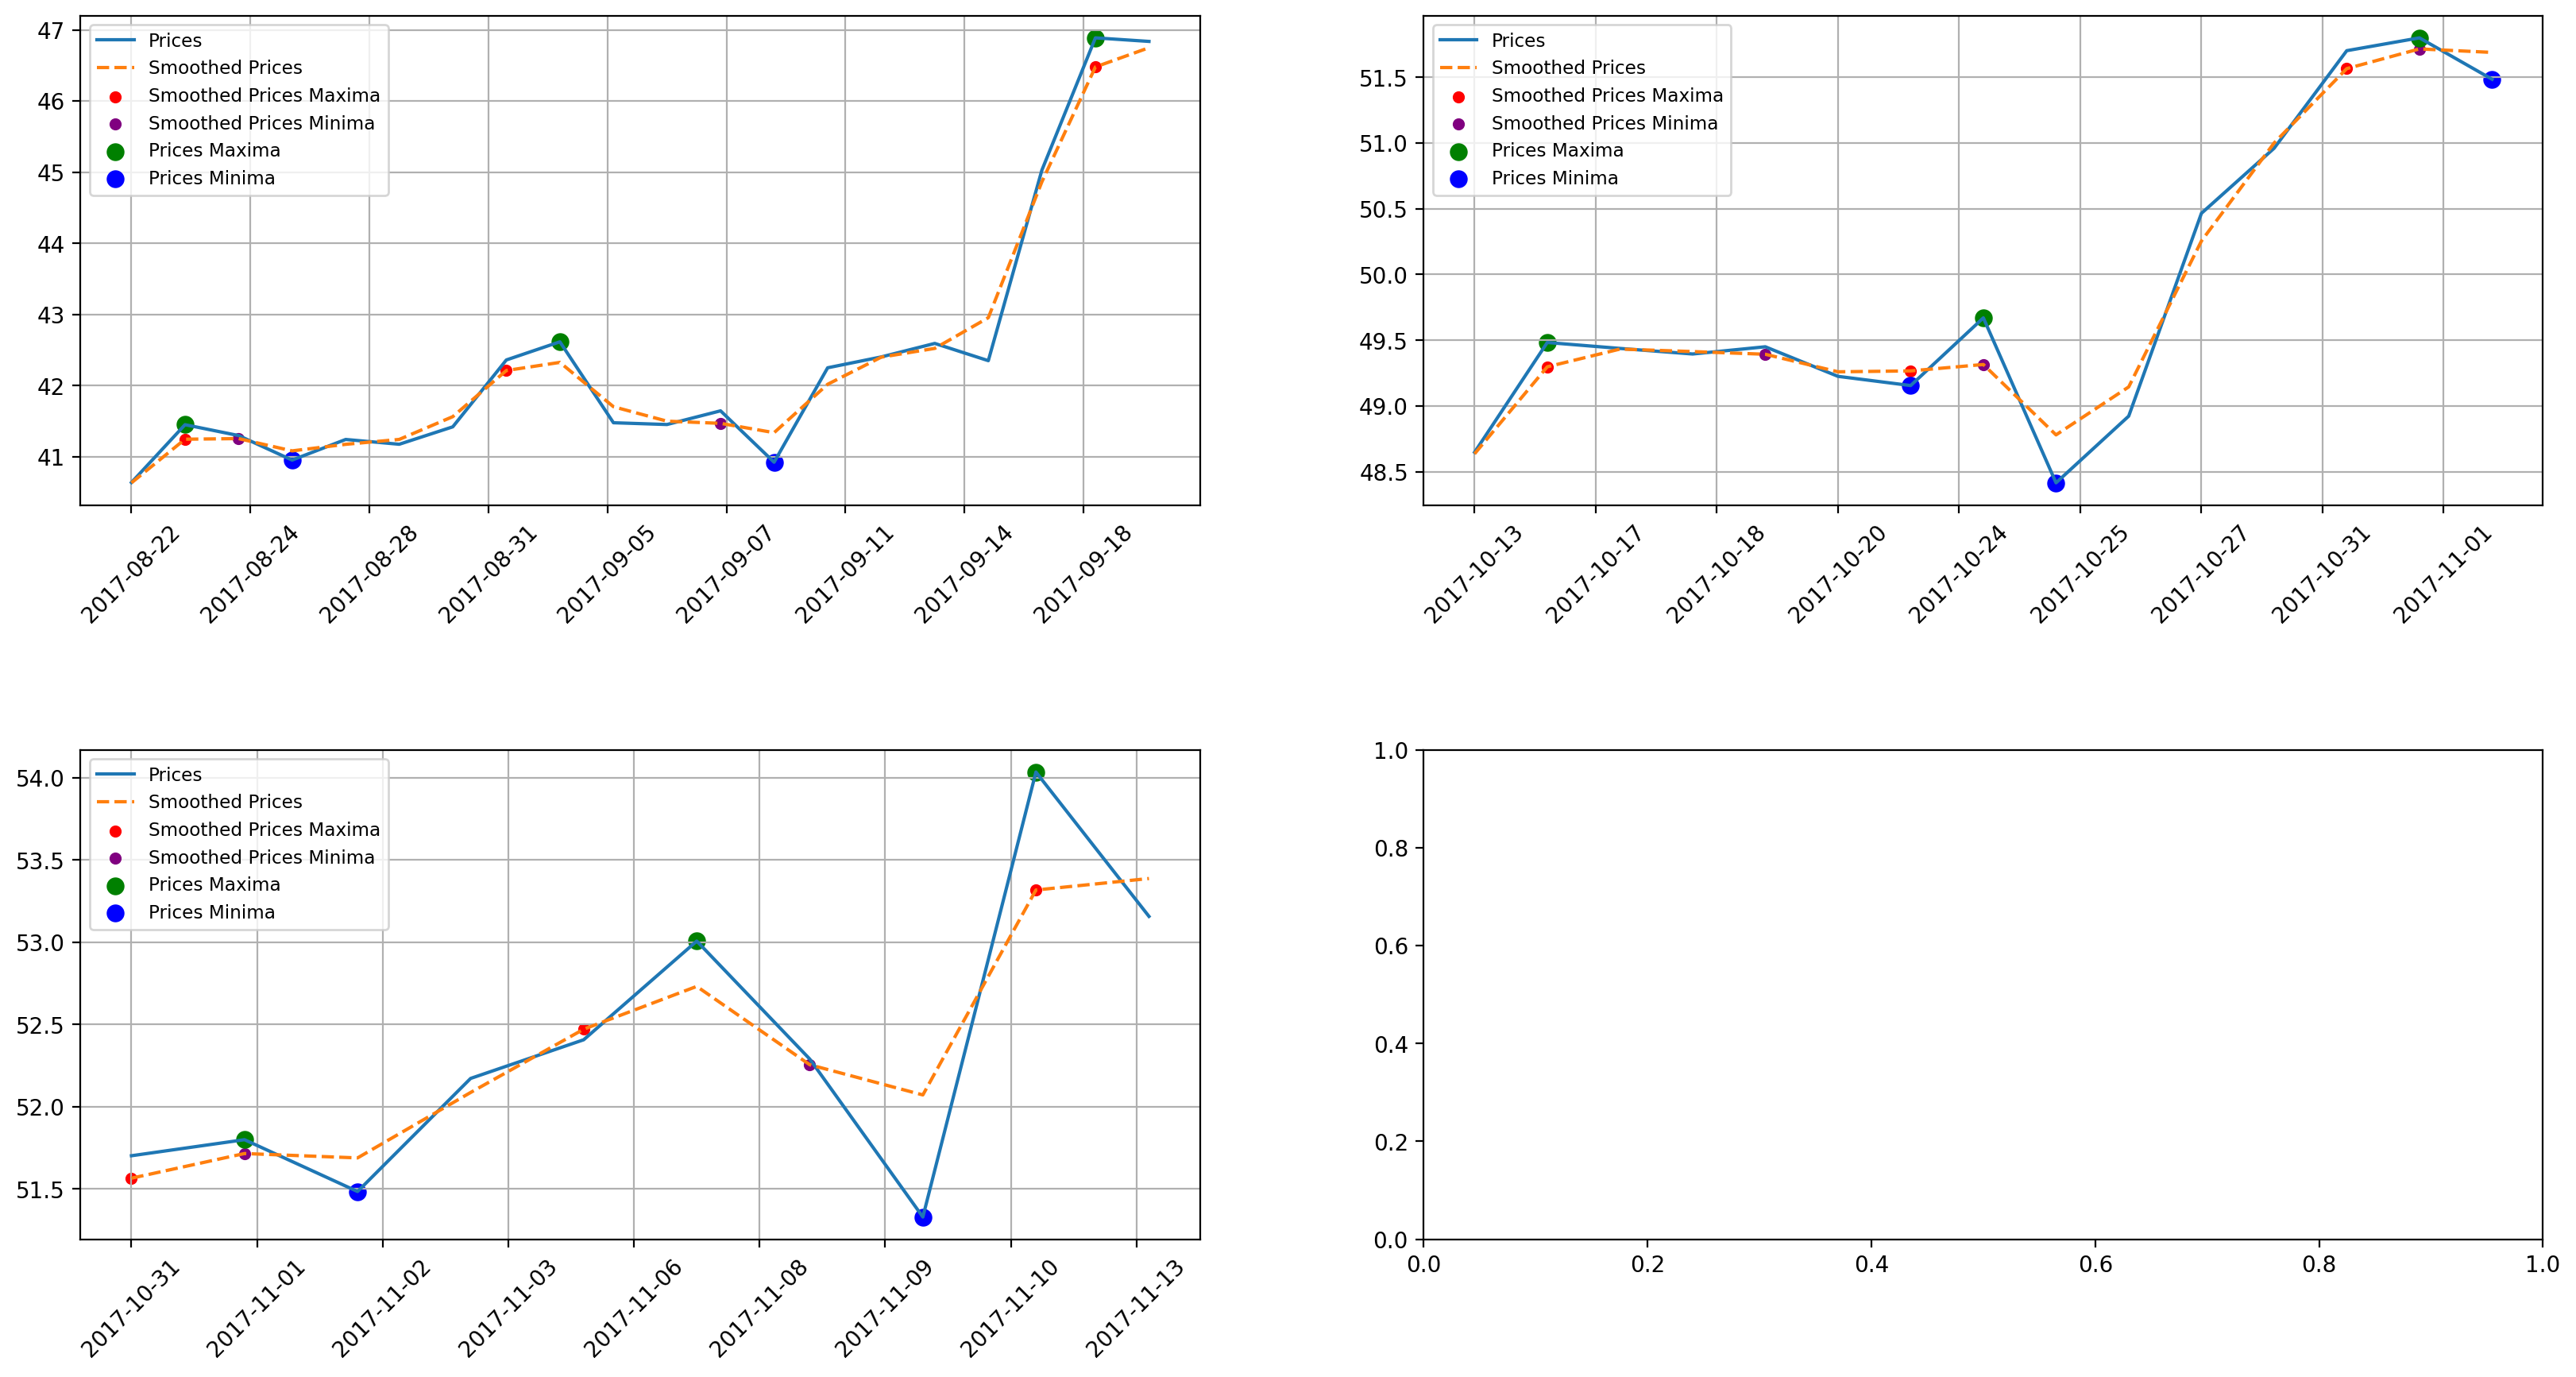

In [58]:
visualize_patterns(dates, prices, smooth_prices,
                       smooth_prices_max_indices, smooth_prices_min_indices,
                       price_max_indices, price_min_indices,
                       patterns, shorthand_fullname_dict)